## 3. Feature validation
To group stations based on their extracted features, we apply k-means clustering to the feature space spanned by DPI, WSD, and SDI. Prior to clustering, all features are standardised to ensure equal weighting.

In [1]:
import polars as pl
from analysis.characterisation.notebooks.notebook_config import dl, scaler
from analysis.characterisation.features import build_feature_df

X = build_feature_df(dl)

X_valid = X.filter(pl.col("valid") == True)
X_feat = X_valid.drop(["station", "valid"]).to_numpy()
X_scaled = scaler.fit_transform(X_feat)

## Determination of k
Before fixing the number of clusters, we compute silhouette scores for different values of $k$.

### Elbow Method and Silhoutte Score

#### Silhouette Score

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Where:
- $s(i)$ is the silhouette score for a single sample $i$
- $a(i)$ is the average distance between $i$ and all other points in the same cluster,
- $b(i)$ is the minimum average distance between $i$ and all points in the nearest cluster to which $i$ does not belong.

The silhoutte score ranges between $[-1, 1]$, a higher value indicates more distinct clusters.

[19.013402696093202, 11.091612243067734, 7.600199930665364, 5.189846647098308, 3.6315693395016364, 2.5132467354525003]


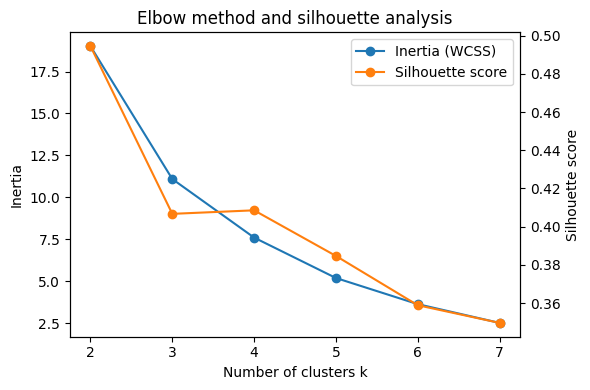

In [2]:
from analysis.characterisation.plotting.plot_clustering import plot_elbow_silhouette

plot_elbow_silhouette(X)

We choose $k=3$ to explicitly capture an intermediate mixed usage type, accepting a moderate reduction in geometric separation in favor of interpretability.

In [3]:
N_CLUSTERS = 3

$k=3$ reflects the conceptual distinction between **recreational-oriented**, **utilitarian-oriented**, and **mixed** usage types introduced earlier. Rather than optimising purely geometric separation metrics, this choice prioritises **interpretability** and alignment with the underlying traffic behaviour assumptions.

In [4]:
from analysis.characterisation.clustering import kmeans_clustering

X = kmeans_clustering(features=X, k=N_CLUSTERS)

features_to_scale = [col for col in X.columns if col not in ["station", "cluster", "valid"]]

X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

X = X.drop("valid")

In [5]:
X.drop("station").group_by("cluster").mean()

cluster,DPI,WSD,SDI
i32,f64,f64,f64
1,1.002605,1.130385,1.087149
0,0.219091,-0.068944,-0.707738
2,-1.221695,-1.061442,-0.379411


### Feature discrimination across clusters

Before we continue let's check how much the features to discriminate between the clusters. To assess this we inspect their distributions using boxplots.

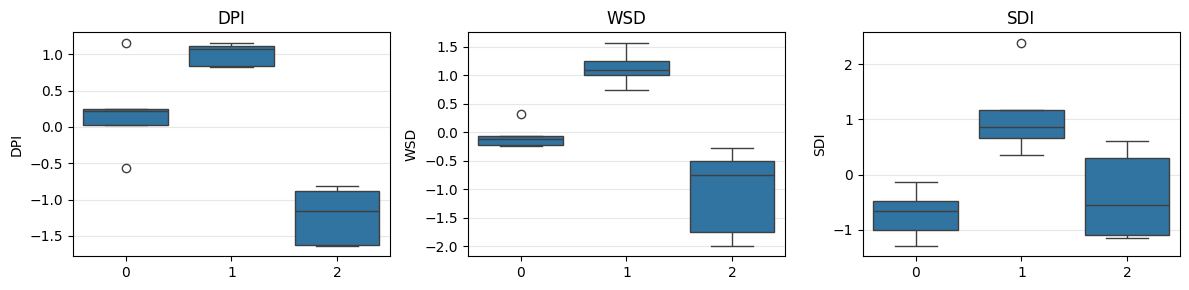

In [6]:
from analysis.characterisation.plotting.plot_features import plot_feature_boxplots

EXCLUDE = {"station", "valid", "cluster", "date"}

FEATURES = [
    c for c in X.columns
    if c not in EXCLUDE and X[c].dtype in (pl.Float32, pl.Float64)
]

plot_feature_boxplots(
    X,
    features=FEATURES,
    cluster_col="cluster",
    clusters=(0, 1, 2),
)

**DPI:** shows clear separation between clusters, with one cluster exhibiting pronounced weekday double-peak structures typical of commuting traffic, while another cluster displays consistently low DPI values, indicating the absence of work-related patterns.

**WSD:** strongly differentiates the clusters, separating stations with substantial weekday–weekend contrasts from those with similar daily profiles throughout the week.

**SDI:** separation is less pronounced, it supports the distinction between clusters with stable year-round usage and those with stronger seasonal dependence.

### Feature correlation

In [7]:
X.select(FEATURES).corr()

DPI,WSD,SDI
f64,f64,f64
1.0,0.832245,0.386217
0.832245,1.0,0.634934
0.386217,0.634934,1.0


We observe a strong correlation between **DPI** and **WSD**.  
High **DPI** ⇒ pronounced weekday commuting peaks ⇒ strong structural differences between weekday and weekend profiles (absence of commuting peaks on weekends) ⇒ high **WSD**.

Although correlated, the features are not redundant: **DPI** captures the strength of commuting-related peak structure, while **WSD** quantifies the overall weekday–weekend shape difference. 

### 3D Normalized Feature Space with Cluster assignments

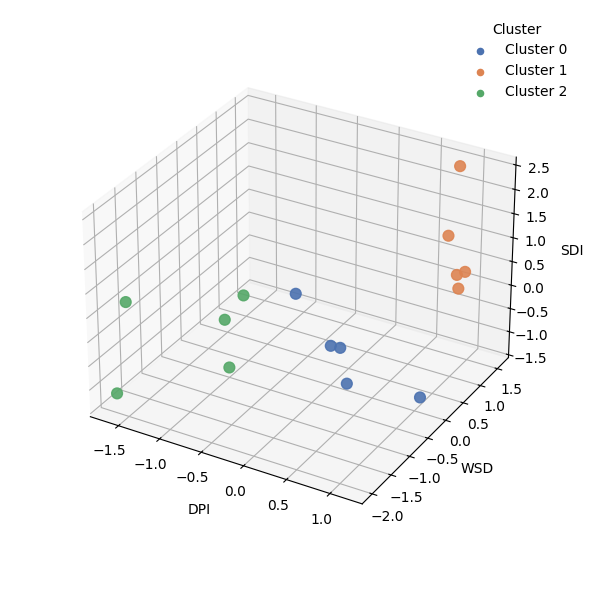

In [8]:
from analysis.characterisation.plotting.plot_features import plot_feature_space

plot_feature_space(X=X, cluster_col="cluster")

### PCA
Reducing the standardized feature space to two dimensions using PCA. This allows us to further explore the feature space 
Using the first two components the majority of variance is explained. 

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

X_pca_pl = (
    X_valid
    .with_columns([
        pl.Series("PC1", X_pca[:, 0]),
        pl.Series("PC2", X_pca[:, 1]),
    ])
    .join(X.select(["station", "cluster"]), on="station")
)
X_pca_pl

Explained variance: [0.75108211 0.2107186 ]


station,DPI,WSD,SDI,valid,PC1,PC2,cluster
str,f64,f64,f64,bool,f64,f64,i32
"""Ziegelhäuser Landstraße""",0.030285,0.080479,0.531836,true,1.880492,0.319605,1
"""Bahnstadtpromenade""",0.033136,0.078063,0.487909,true,1.675032,-0.229423,1
"""Berliner Straße Querschnitt""",0.009011,0.057259,0.384064,true,-1.130838,0.237554,2
"""Gaisbergstraße""",0.023613,0.058057,0.39111,true,-0.260356,-0.476394,0
"""Eppelheimer Str. Querschnitt""",0.012655,0.05384,0.456739,true,-0.649852,0.765643,2
…,…,…,…,…,…,…,…
"""Thedor-Heuss-Brücke Querschnit…",0.011926,0.050217,0.33746,true,-1.544499,-0.301048,2
"""Hardtstraße""",0.032738,0.076721,0.461496,true,1.441138,-0.448452,1
"""Rohrbacher Straße Querschnitt""",0.023985,0.059674,0.320781,true,-0.585251,-1.179721,0


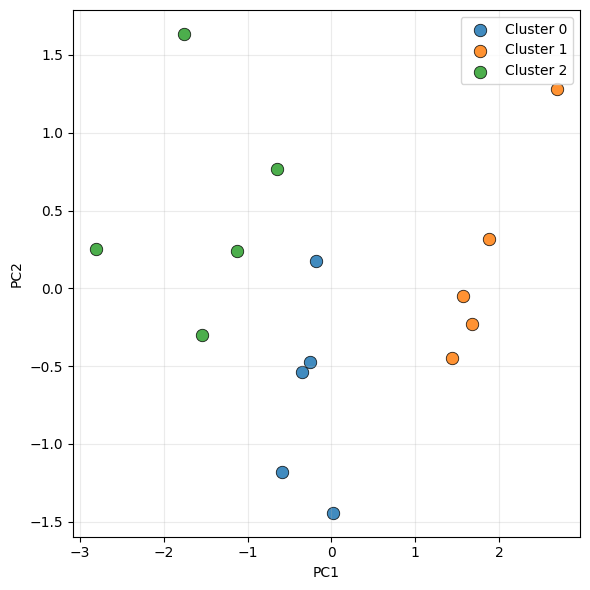

In [10]:
from analysis.characterisation.plotting.plot_pca import plot_pca_clusters

plot_pca_clusters(
    X_pca_pl,
    annotate=False
)

### Random Forest Feature Importance

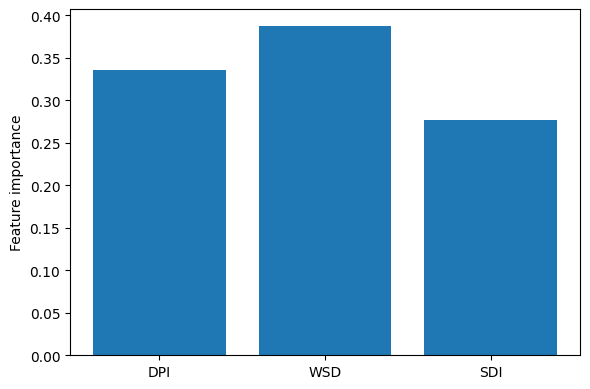

In [11]:
from analysis.characterisation.plotting.plot_features import plot_rf_importance

plot_rf_importance(X_pca_pl, FEATURES)